In [1]:
from google.colab import files
uploaded = files.upload()


Saving merged_no_duplicates.csv to merged_no_duplicates.csv


In [2]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import StandardScaler

In [3]:
df = pd.read_csv("merged_no_duplicates.csv")

In [4]:
print("Missing values:\n", df.isna().sum())

Missing values:
 Unnamed: 0.1                      0
Unnamed: 0                        0
spotify_id                        0
name                              0
artists                           0
danceability                      0
energy                            0
key                               0
loudness                          0
mode                              0
speechiness                       0
acousticness                      0
instrumentalness                  0
liveness                          0
valence                           0
tempo                             0
kmeans_features7                  0
lyrics                            0
summary                          14
lyrics_audio_features_summary    32
mood                              1
dtype: int64


In [5]:
df = df.dropna(subset=[
    'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
    'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'lyrics_audio_features_summary'
])

In [6]:
# Drop rows where summary embeddings are missing
df = df.dropna(subset=['lyrics_audio_features_summary']).reset_index(drop=True)

print(f"Remaining rows: {len(df)}")


Remaining rows: 4790


In [7]:
duplicates = df[df.duplicated(subset=['name', 'artists'], keep=False)]

# Show how many duplicates
print(f"Number of duplicate entries (name + artist): {len(duplicates)}")

# Display the duplicate rows (if any)
duplicates

Number of duplicate entries (name + artist): 0


Empty DataFrame
Columns: [Unnamed: 0.1, Unnamed: 0, spotify_id, name, artists, danceability, energy, key, loudness, mode, speechiness, acousticness, instrumentalness, liveness, valence, tempo, kmeans_features7, lyrics, summary, lyrics_audio_features_summary, mood]
Index: []

[0 rows x 21 columns]

In [8]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

# List of audio feature columns
audio_cols = [
    'valence', 'tempo', 'danceability', 'energy', 'key',
    'loudness', 'mode', 'speechiness', 'acousticness',
    'instrumentalness', 'liveness'
]

# Standardize audio features
scaler = StandardScaler()
scaled_audio = scaler.fit_transform(df[audio_cols])

# Add scaled features to the DataFrame with new column names
for i, col in enumerate(audio_cols):
    df[f'{col}_scaled'] = scaled_audio[:, i]

# Optional: View first few rows
print(df[[col for col in df.columns if 'scaled' in col]].head())


   valence_scaled  tempo_scaled  danceability_scaled  energy_scaled  \
0       -0.590834     -0.903089            -0.466516       0.346309   
1        0.291252      1.183181            -0.652033      -0.406619   
2       -0.167611      2.166316            -1.826975      -0.535853   
3       -0.252256      2.099918             0.096907       0.267645   
4       -1.192257      0.670262            -0.425290       0.172124   

   key_scaled  loudness_scaled  mode_scaled  speechiness_scaled  \
0    1.561715         0.894397     0.840866           -0.763374   
1    1.288540        -0.396866    -1.189250            1.376426   
2   -1.170032        -0.671136     0.840866           -0.449995   
3   -0.350508         0.467047     0.840866            0.378912   
4    0.195842         0.402200    -1.189250           -0.755429   

   acousticness_scaled  instrumentalness_scaled  liveness_scaled  
0            -0.945497                -0.194630        -0.528429  
1            -0.504220              

## Embeddings for Summaries of features+lyrics

In [9]:

model = SentenceTransformer('all-mpnet-base-v2')

# Embed the lyrics + audio summaries
df['summary_embedding'] = model.encode(
    df['lyrics_audio_features_summary'].tolist(),
    show_progress_bar=True
).tolist()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/150 [00:00<?, ?it/s]

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np

# Step 1: Get scaled audio feature matrix
scaled_audio_cols = [f'{col}_scaled' for col in audio_cols]
scaled_audio_matrix = df[scaled_audio_cols].values

# Step 2: Get summary embeddings matrix
embeddings = np.array(df['summary_embedding'].tolist())

# Step 3: Concatenate embeddings + scaled audio
combined_features = np.hstack([embeddings, scaled_audio_matrix])

# Step 4: Standardize the combined feature matrix
scaler_combined = StandardScaler()
combined_scaled = scaler_combined.fit_transform(combined_features)

# Step 5: Apply PCA (retain 95% variance)
pca_combined = PCA(n_components=0.95, random_state=42)
reduced_features = pca_combined.fit_transform(combined_scaled)

# Step 6: Save reduced vectors to DataFrame
df['reduced_vector'] = reduced_features.tolist()

# Optional: Check resulting dimension
print(f"Combined input dim: {combined_features.shape[1]}")
print(f"PCA-reduced dim: {reduced_features.shape[1]}")


Combined input dim: 779
PCA-reduced dim: 178


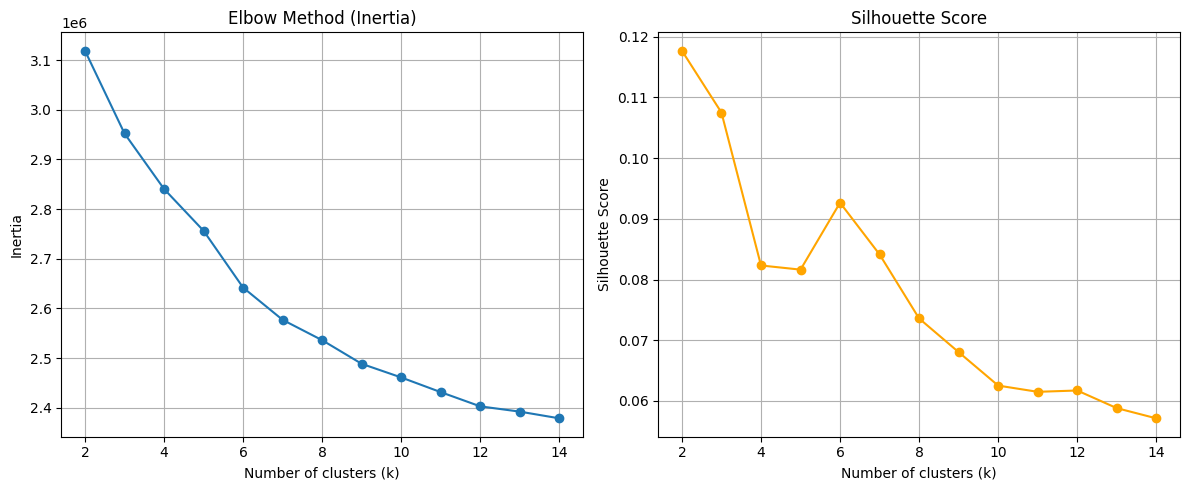

In [11]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Prepare reduced vector matrix
X = np.array(df['reduced_vector'].tolist())

inertia = []
silhouette = []
k_range = range(2, 15)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X, labels))

# Plot Elbow (Inertia)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method (Inertia)')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)

# Plot Silhouette Scores
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette, marker='o', color='orange')
plt.title('Silhouette Score')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)

plt.tight_layout()
plt.show()


In [12]:
from sklearn.cluster import KMeans

# Run KMeans on PCA-reduced vectors
k = 6
kmeans = KMeans(n_clusters=k, random_state=42)
df['cluster_label'] = kmeans.fit_predict(np.array(df['reduced_vector'].tolist()))

# Optional: print how many songs per cluster
print(df['cluster_label'].value_counts().sort_index())


cluster_label
0     790
1     795
2    1364
3     730
4     997
5     114
Name: count, dtype: int64


In [13]:
print(df.columns)

Index(['Unnamed: 0.1', 'Unnamed: 0', 'spotify_id', 'name', 'artists',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'kmeans_features7', 'lyrics', 'summary',
       'lyrics_audio_features_summary', 'mood', 'valence_scaled',
       'tempo_scaled', 'danceability_scaled', 'energy_scaled', 'key_scaled',
       'loudness_scaled', 'mode_scaled', 'speechiness_scaled',
       'acousticness_scaled', 'instrumentalness_scaled', 'liveness_scaled',
       'summary_embedding', 'reduced_vector', 'cluster_label'],
      dtype='object')


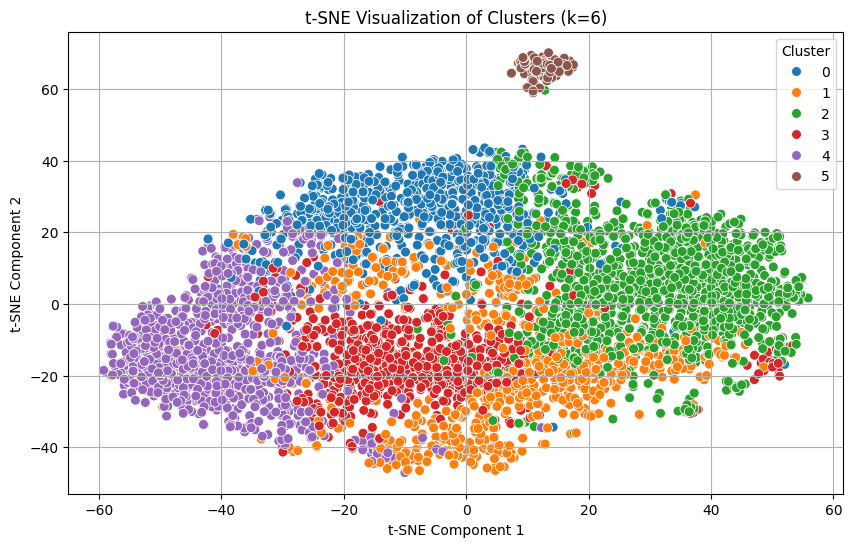

In [15]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Prepare data
#X = np.array(df['reduced_vector'].tolist())
labels = df['cluster_label']

# Apply t-SNE to 2D
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_2d = tsne.fit_transform(X)

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], hue=labels, palette='tab10', s=50)
plt.title('t-SNE Visualization of Clusters (k=6)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()


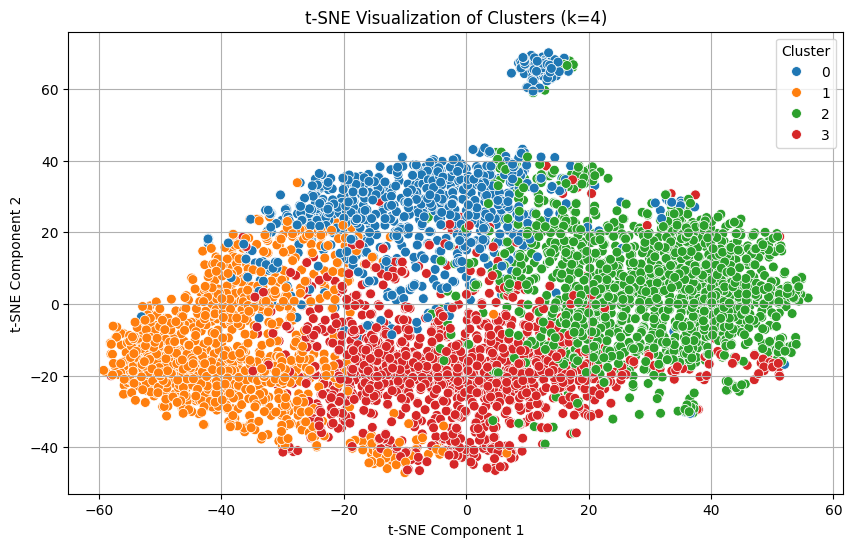

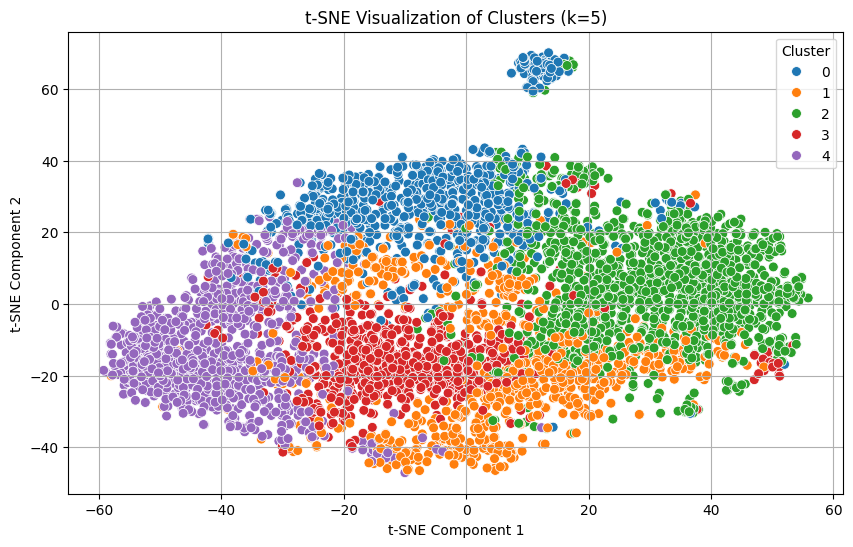

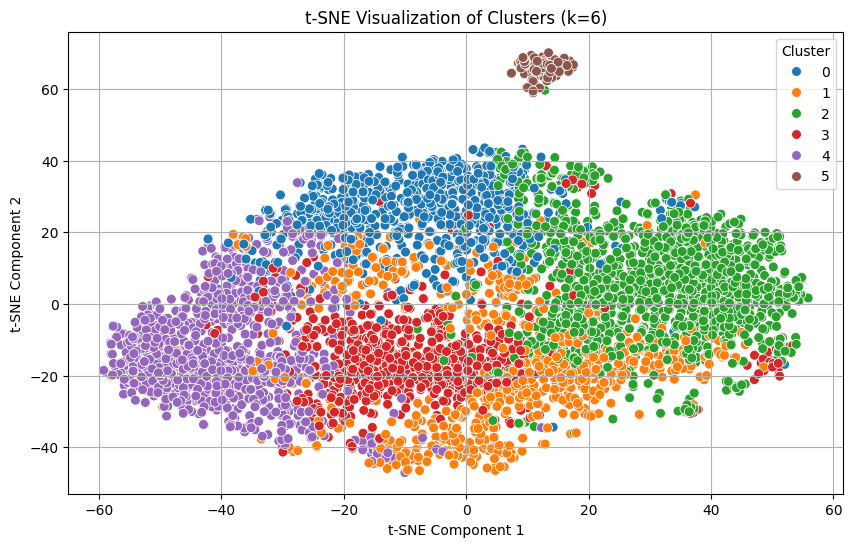

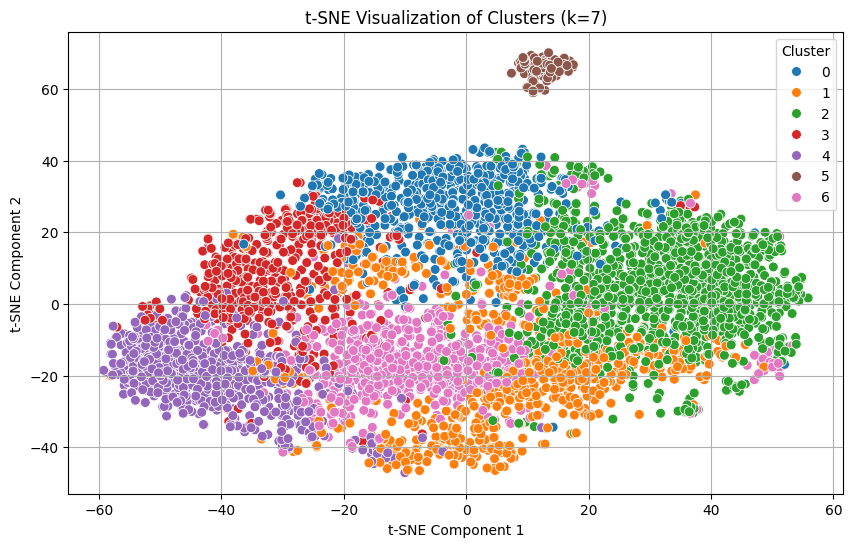

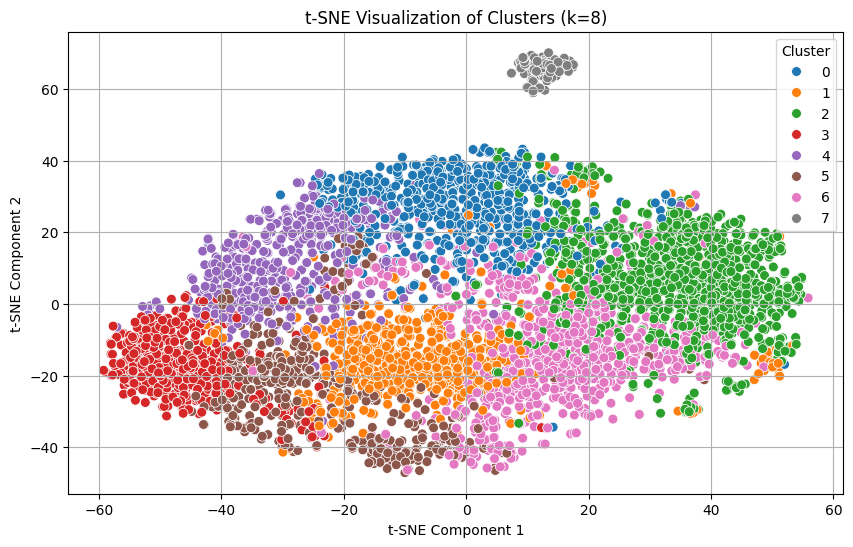

In [16]:
for k in range(4, 9):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], hue=labels, palette='tab10', s=50)
    plt.title(f't-SNE Visualization of Clusters (k={k})')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.legend(title='Cluster')
    plt.grid(True)
    plt.show()












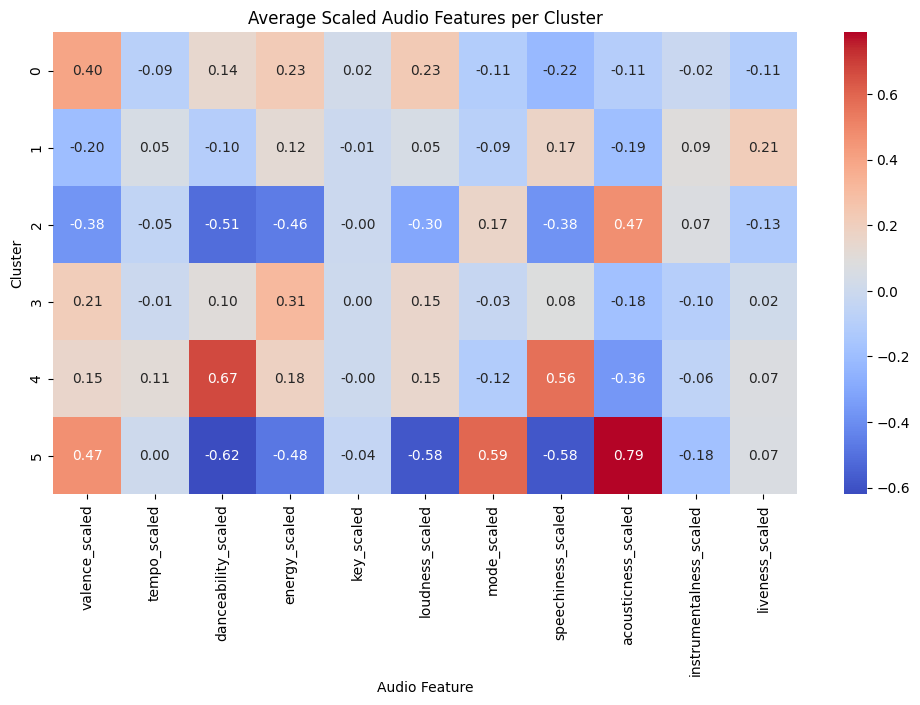

In [17]:
# Compute mean of scaled audio features per cluster
cluster_feature_means = df.groupby('cluster_label')[[f"{col}_scaled" for col in audio_cols]].mean()

# Optional: Plot as heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.heatmap(cluster_feature_means, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Average Scaled Audio Features per Cluster")
plt.xlabel("Audio Feature")
plt.ylabel("Cluster")
plt.show()


In [18]:
# Show 3 random song summaries per cluster
for cluster in sorted(df['cluster_label'].unique()):
    print(f"\n--- Cluster {cluster} ---")
    sample = df[df['cluster_label'] == cluster]['lyrics_audio_features_summary'].sample(3, random_state=42)
    for idx, text in enumerate(sample):
        print(f"({idx+1}) {text[:300]}...\n")  # Show first 300 chars of each



--- Cluster 0 ---
(1) This track evokes a playful, youthful energy, portraying a fleeting summer romance with a carefree attitude. The lyrical content hints at a story of young love and a sense of rebellion, exploring themes of attraction and embracing a moment without deep reflection. It feels like a snapshot of a caref...

(2) This track conveys a deeply emotional narrative centered around finding solace and unwavering devotion in another person. The song explores themes of loneliness, searching, and ultimately, the profound relief of finding a connection that feels complete and destined. It speaks to overcoming personal ...

(3) This song portrays a tender, quietly unfolding romance, depicted through seemingly small, intimate moments – shared coffee, burnt toast, stolen kisses. The narrative conveys a sense of hesitant vulnerability and the gradual realization of deep affection, suggesting a connection that transcends typic...


--- Cluster 1 ---
(1) This track paints a vivid portr

In [19]:
# Show 5 example songs from each cluster
for cluster in sorted(df['cluster_label'].unique()):
    print(f"\n--- 🎧 Cluster {cluster} ---")
    sample = df[df['cluster_label'] == cluster][['name', 'artists']].sample(5, random_state=42)
    print(sample.to_string(index=False))



--- 🎧 Cluster 0 ---
                              name               artists
                        Diet Pepsi           Addison Rae
                          One Love                 TZUYU
You Are In Love (Taylor's Version)          Taylor Swift
                          Familiar  Liam Payne, J Balvin
                              Лиза FACE, Squirrel Flower

--- 🎧 Cluster 1 ---
                                    name                      artists
Liquor Store Blues (feat. Damian Marley)    Bruno Mars, Damian Marley
                                 Bandito            Twenty One Pilots
                                Downfall                        ANITA
                   What Is This Feeling? Ariana Grande, Cynthia Erivo
                                Paranoid                  Post Malone

--- 🎧 Cluster 2 ---
                       name      artists
         Moral of the Story         Ashe
                  Down Hill        Drake
                   do re mi    blackbear
  Bigger Th

In [20]:
# Export DataFrame to CSV including cluster label
df.to_csv("songs_with_clusters_lyrics_features_embeddings.csv", index=False)
print(" Exported to songs_with_clusters.csv")


 Exported to songs_with_clusters.csv


##considering only few features

In [21]:
selected_audio = df[
    ['valence_scaled', 'energy_scaled', 'danceability_scaled', 'tempo_scaled',
     'acousticness_scaled', 'instrumentalness_scaled', 'loudness_scaled', 'mode_scaled']
].values


In [22]:

combined_selected_features = np.hstack([embeddings, selected_audio])

In [23]:
scaler_selected = StandardScaler()
combined_selected = scaler_selected.fit_transform(combined_selected_features)

#standardizing combined features and PCA

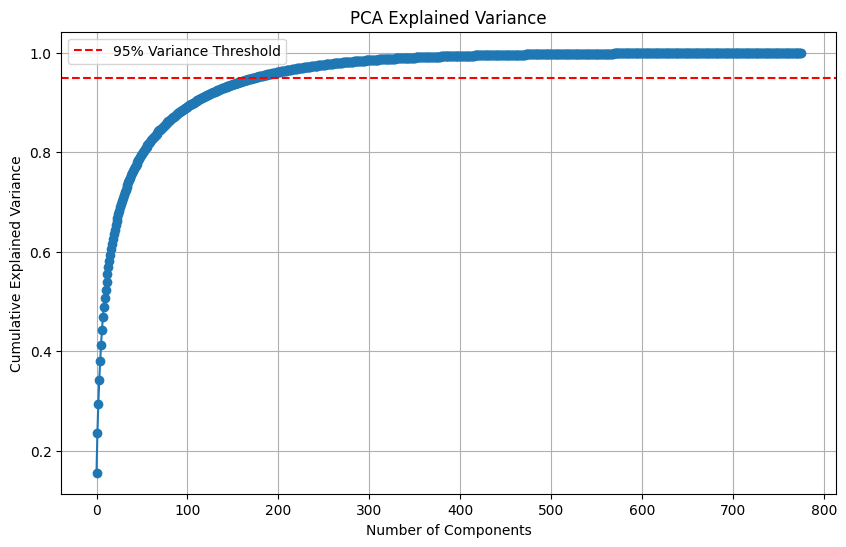

In [24]:
pca_full = PCA().fit(combined_selected)

# Plot cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca_full.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid(True)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance Threshold')
plt.legend()
plt.show()

In [25]:
pca_selected = PCA(n_components=0.95, random_state=42)
reduced_selected = pca_selected.fit_transform(combined_selected)

# Step 6: Save new reduced vectors
df['reduced_vector_selected'] = reduced_selected.tolist()

In [26]:
print("Original shape before PCA:", combined_selected.shape)

print("Number of PCA components selected:", pca_selected.n_components_)


Original shape before PCA: (4790, 776)
Number of PCA components selected: 176


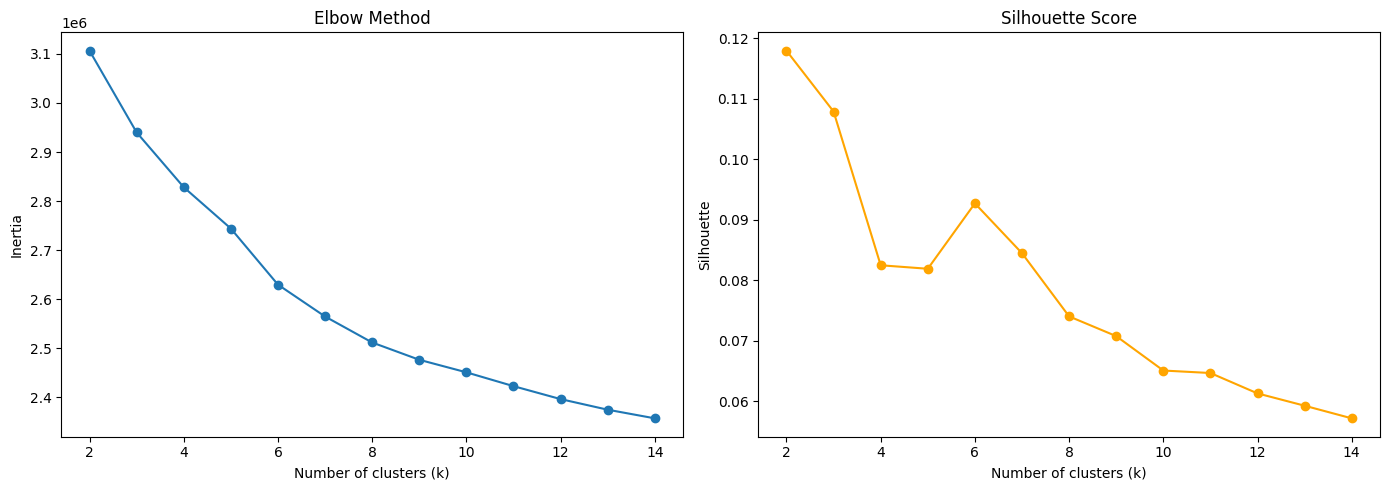

In [27]:
# Step 7: Convert reduced vectors to array
X_SELECTED = np.array(df['reduced_vector_selected'].tolist())

# Step 8: Try different values of k
inertias_selected = []
silhouette_scores_selected = []
K_range = range(2, 15)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_SELECTED)
    inertias_selected.append(kmeans.inertia_)
    silhouette_scores_selected.append(silhouette_score(X_SELECTED, labels))

# Step 9: Plot elbow and silhouette
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

axs[0].plot(K_range, inertias_selected, marker='o')
axs[0].set_title('Elbow Method')
axs[0].set_xlabel('Number of clusters (k)')
axs[0].set_ylabel('Inertia')

axs[1].plot(K_range, silhouette_scores_selected, marker='o', color='orange')
axs[1].set_title('Silhouette Score')
axs[1].set_xlabel('Number of clusters (k)')
axs[1].set_ylabel('Silhouette')

plt.tight_layout()
plt.show()

In [28]:
best_k = 6
final_kmeans = KMeans(n_clusters=best_k, random_state=42)
df['cluster_selected'] = final_kmeans.fit_predict(X)

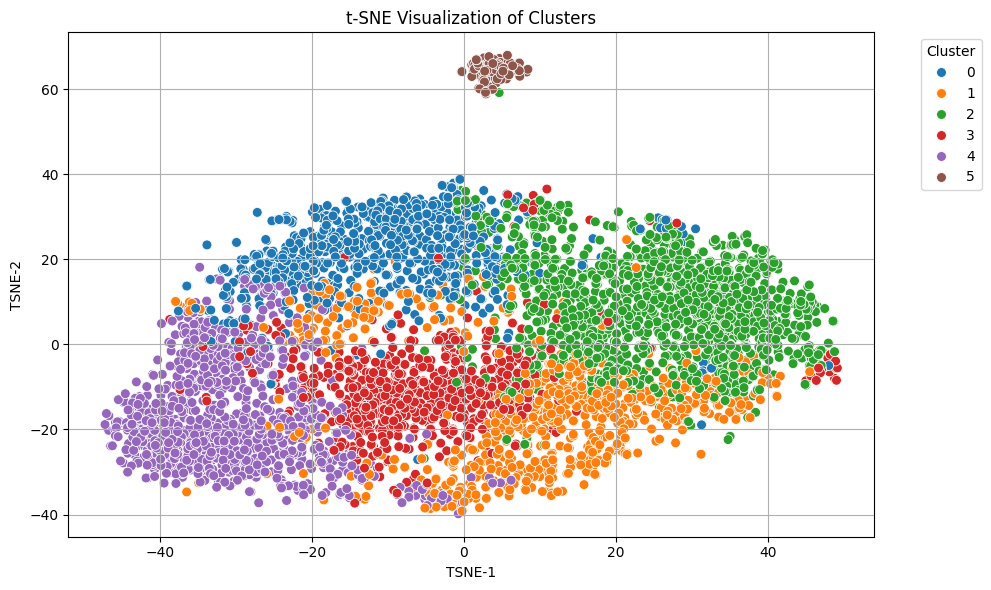

In [29]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Step 1: Extract reduced vectors and cluster labels
X = np.array(df['reduced_vector_selected'].tolist())
labels = df['cluster_selected']

# Step 2: t-SNE (2D projection)
tsne = TSNE(n_components=2, perplexity=40, random_state=42)
X_tsne = tsne.fit_transform(X)

# Step 3: Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=labels, palette='tab10', s=50)
plt.title('t-SNE Visualization of Clusters')
plt.xlabel('TSNE-1')
plt.ylabel('TSNE-2')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


In [30]:
cluster_counts = df['cluster_selected'].value_counts().sort_index()

# Print the counts
print("Number of songs per cluster:")
print(cluster_counts)

Number of songs per cluster:
cluster_selected
0     790
1     795
2    1364
3     730
4     997
5     114
Name: count, dtype: int64


In [31]:
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering, SpectralClustering, DBSCAN

In [32]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

In [33]:
def evaluate_clustering(name, labels, X, X_tsne):
    sil = silhouette_score(X, labels) if len(set(labels)) > 1 else -1
    ch = calinski_harabasz_score(X, labels) if len(set(labels)) > 1 else -1
    db = davies_bouldin_score(X, labels) if len(set(labels)) > 1 else -1

    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=labels, palette='tab10', s=40)
    plt.title(f'{name} Clustering')
    plt.xlabel('TSNE-1'); plt.ylabel('TSNE-2')
    plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.grid(True)
    plt.show()

    print(f" {name} Scores:")
    print(f"  Silhouette Score: {sil:.4f}")
    print(f"  Calinski-Harabasz Index: {ch:.2f}")
    print(f"  Davies-Bouldin Score: {db:.4f}\n")
    return {'model': name, 'silhouette': sil, 'ch_index': ch, 'db_index': db}

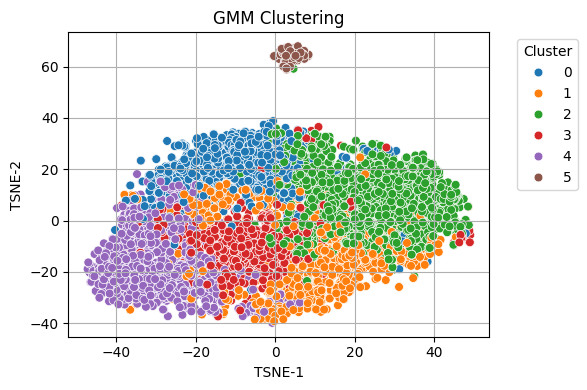

 GMM Scores:
  Silhouette Score: 0.0910
  Calinski-Harabasz Index: 321.91
  Davies-Bouldin Score: 2.5183



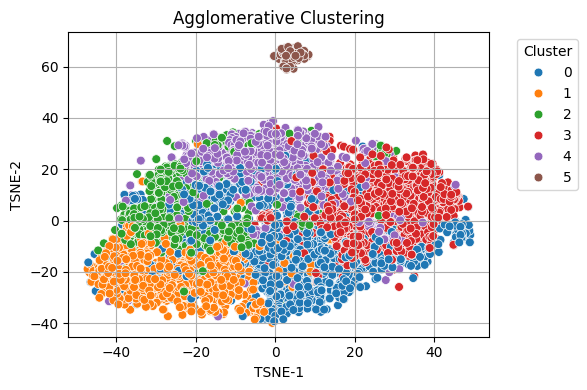

 Agglomerative Scores:
  Silhouette Score: 0.0555
  Calinski-Harabasz Index: 259.79
  Davies-Bouldin Score: 2.9275



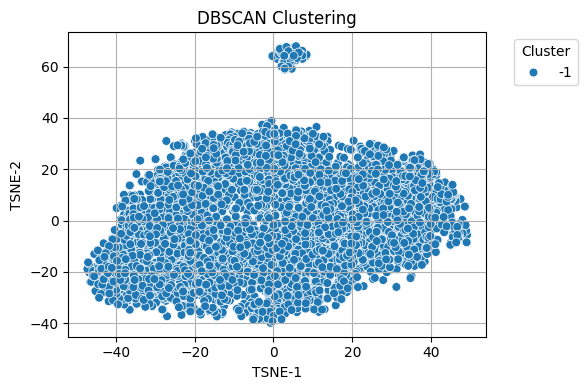

 DBSCAN Scores:
  Silhouette Score: -1.0000
  Calinski-Harabasz Index: -1.00
  Davies-Bouldin Score: -1.0000

Model Comparison:
           model  silhouette    ch_index  db_index
0            GMM    0.091009  321.910525  2.518342
1  Agglomerative    0.055508  259.793619  2.927477
2         DBSCAN   -1.000000   -1.000000 -1.000000


In [35]:
results = []

# GMM
gmm = GaussianMixture(n_components=6, random_state=42)
gmm_labels = gmm.fit_predict(X)
results.append(evaluate_clustering("GMM", gmm_labels, X, X_tsne))

# Agglomerative Clustering
agg = AgglomerativeClustering(n_clusters=6)
agg_labels = agg.fit_predict(X)
results.append(evaluate_clustering("Agglomerative", agg_labels, X, X_tsne))


# DBSCAN
dbscan = DBSCAN(eps=2.5, min_samples=5)  # You may need to tune eps
dbscan_labels = dbscan.fit_predict(X)
results.append(evaluate_clustering("DBSCAN", dbscan_labels, X, X_tsne))

# Summary Table
comparison_df = pd.DataFrame(results)
print("Model Comparison:")
print(comparison_df.sort_values(by="silhouette", ascending=False))

In [37]:
# Extract features and KMeans labels
X_kmeans = np.array(df['reduced_vector_selected'].tolist())
labels_kmeans = df['cluster_selected']

# Compute clustering metrics for KMeans
sil_kmeans = silhouette_score(X_kmeans, labels_kmeans)
ch_kmeans = calinski_harabasz_score(X_kmeans, labels_kmeans)
db_kmeans = davies_bouldin_score(X_kmeans, labels_kmeans)

# Add to model comparison
results.append({
    'model': 'KMeans',
    'silhouette': sil_kmeans,
    'ch_index': ch_kmeans,
    'db_index': db_kmeans
})


In [40]:
results_df = pd.DataFrame(results)
results_df.sort_values(by='silhouette', ascending=False, inplace=True)
display(results_df)


model  silhouette    ch_index  db_index
3         KMeans    0.092933  328.532426  2.489514
0            GMM    0.091009  321.910525  2.518342
1  Agglomerative    0.055508  259.793619  2.927477
2         DBSCAN   -1.000000   -1.000000 -1.000000

##so best is to use kmeans as it has high silhouette score and ch index compared to others and low d_index

#tried improvising dbscan but due to high dimension it is not performing great

In [41]:

best_score = -1
best_params = {}
results = []

for eps in np.linspace(1.0, 5.0, 9):  # Try eps values from 1.0 to 5.0
    for min_samples in [3, 5, 10]:
        db = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
        labels = db.labels_

        # Ignore runs where all points assigned to one cluster or all noise
        if len(set(labels)) <= 1 or len(set(labels)) == len(X):
            continue

        score = silhouette_score(X, labels)
        results.append((eps, min_samples, score))

        if score > best_score:
            best_score = score
            best_params = {'eps': eps, 'min_samples': min_samples}

print("Best DBSCAN Params:", best_params)
print("Best Silhouette Score:", best_score)


Best DBSCAN Params: {}
Best Silhouette Score: -1
